In [1]:
# import libraries
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '15'

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, Ridge

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, Normalizer, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import skew

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [2]:
# read the dataframe
df = pd.read_csv('../data/Addis_Ababa_Solcast_clean.csv')

In [3]:
# feature engineering
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['Year'] = df['date'].dt.year
df['Day'] = df['date'].dt.day

In [4]:
df = df.drop(columns=['date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    1091 non-null   float64
 1   CloudOpacity   1091 non-null   float64
 2   DHI            1091 non-null   float64
 3   DNI            1091 non-null   float64
 4   Radiation      1091 non-null   float64
 5   Precipitation  1091 non-null   float64
 6   Humidity       1091 non-null   float64
 7   Pressure       1091 non-null   float64
 8   WindDirection  1091 non-null   float64
 9   WindSpeed      1091 non-null   float64
 10  Sunrise        1091 non-null   int64  
 11  Sunset         1091 non-null   int64  
 12  Month          1091 non-null   int64  
 13  Year           1091 non-null   int64  
 14  Day            1091 non-null   int64  
dtypes: float64(10), int64(5)
memory usage: 128.0 KB


## Split the data

In [6]:
from sklearn.model_selection import train_test_split 
# stratify also along the month column
# check that the rain ratio per month is equal between train and test set
df_train, df_test = train_test_split(df, test_size=0.15, stratify=df[['Month']]) 
df_train, df_validation = train_test_split(df_train, test_size=0.2, stratify=df_train[['Month']]) 

print("Size of train:", round(len(df_train)/len(df)*100, 2), "% of original dataframe")
print("Size of validation:", round(len(df_validation)/len(df)*100, 2), "% of original dataframe")
print("Size of test:", round(len(df_test)/len(df)*100, 2), "% of original dataframe")


Size of train: 67.92 % of original dataframe
Size of validation: 17.05 % of original dataframe
Size of test: 15.03 % of original dataframe


In [7]:
df_train.to_csv('../data/train.csv', index=False)
df_validation.to_csv('../data/validation.csv', index=False)
df_test.to_csv('../data/test.csv', index=False)

In [8]:
def get_features_and_label(df):
    label = np.ravel(np.array(df['Radiation']).T)
    features = df.drop(columns=['Radiation']).to_numpy()
    return features, label

In [9]:
#Split the data into X and y
X_train, y_train = get_features_and_label(df_train)
X_test, y_test = get_features_and_label(df_test)

In [10]:
X_train.shape, y_train.shape

((741, 14), (741,))

## Modeling

In [11]:
skewed_features = []
for col in df_train.columns.to_list()[:-2]:    
    if col != 'Radiation':
        if((min(df_train[col]) > 0)) & (abs(skew(df_train[col])) > 0):
            skewed_features.append(col)
        
skewed_features

['Temperature',
 'DHI',
 'Precipitation',
 'Humidity',
 'Pressure',
 'WindDirection',
 'WindSpeed',
 'Sunset',
 'Month']

In [12]:
def log_transform(x):
    return np.log(x + 1)

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("month_encoder", OneHotEncoder(handle_unknown="ignore"), ['Month']),
        ("log_transform", FunctionTransformer(log_transform), skewed_features)
    ],
    remainder='passthrough'
)

In [14]:
pipeline = Pipeline([  
    ('preprocessing', preprocessor),
    ('scaler' , StandardScaler()),
    ('model' , RandomForestRegressor())
])

In [15]:
parameters = {
    'preprocessing__month_encoder': ['passthrough', OneHotEncoder(handle_unknown='ignore')],
    'preprocessing__log_transform': ['passthrough', FunctionTransformer(log_transform)],
    'scaler': ['passthrough', StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler()],
    'model': [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor()]
}

In [16]:
X_train = df_train.drop(columns=['Radiation'])
y_train = df_train['Radiation']

X_test = df_test.drop(columns=['Radiation'])
y_test = df_test['Radiation']

In [17]:
X_train

,Temperature,CloudOpacity,DHI,DNI,Precipitation,Humidity,Pressure,WindDirection,WindSpeed,Sunrise,Sunset,Month,Year,Day
150,19.630769,33.392308,226.769231,222.615385,23.738462,67.200000,781.784615,139.230769,1.523077,0,19,5,2019,30
351,16.984615,0.338462,53.692308,776.846154,12.553846,51.223077,765.015385,116.307692,3.269231,0,19,12,2019,17
993,17.430769,36.946154,204.692308,258.461538,20.000000,67.830769,765.315385,114.307692,2.238462,0,19,9,2021,19
646,17.076923,13.430769,167.461538,505.538462,11.561538,48.876923,765.538462,85.153846,3.561538,0,19,10,2020,7
954,17.546154,44.346154,229.384615,155.076923,21.076923,68.207692,764.730769,153.384615,1.538462,0,19,8,2021,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,17.723077,38.184615,280.076923,111.846154,23.738462,70.884615,765.476923,183.692308,2.284615,0,19,9,2019,15
776,19.884615,6.046154,113.769231,618.769231,13.600000,33.361538,765.123077,122.538462,3.407692,0,19,2,2021,14
586,14.838462,53.476923,236.846154,91.769231,26.576923,85.169231,764.638462,235.384615,2.338462,0,19,8,2020,8
1068,17.791667,3.041667,95.000000,722.833333,8.600000,32.008333,765.458333,115.833333,3.200000,0,18,12,2021,3


In [18]:
scoring = {'max_error': 'max_error', 'neg_mean_squared_error': 'neg_mean_squared_error', 'r2':'r2'}

grid = GridSearchCV(pipeline, parameters, cv=5, scoring=scoring, refit='r2', return_train_score=True).fit(X_train, y_train)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
 
# Access the best set of parameters
best_params = grid.best_params_
#print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

Training set score: 0.9817938658731313
Test set score: 0.980037163905801
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('month_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Month']),
                                                 ('log_transform',
                                                  'passthrough',
                                                  ['Temperature', 'DHI',
                                                   'Precipitation', 'Humidity',
                                                   'Pressure', 'WindDirection',
                                                   'WindSpeed', 'Sunset',
                                                   'Month'])])),
                ('scaler', Normalizer()), ('model', LinearRegression())])


## Plotting the predictions

In [19]:
y_pred = best_pipe.predict(X_test)

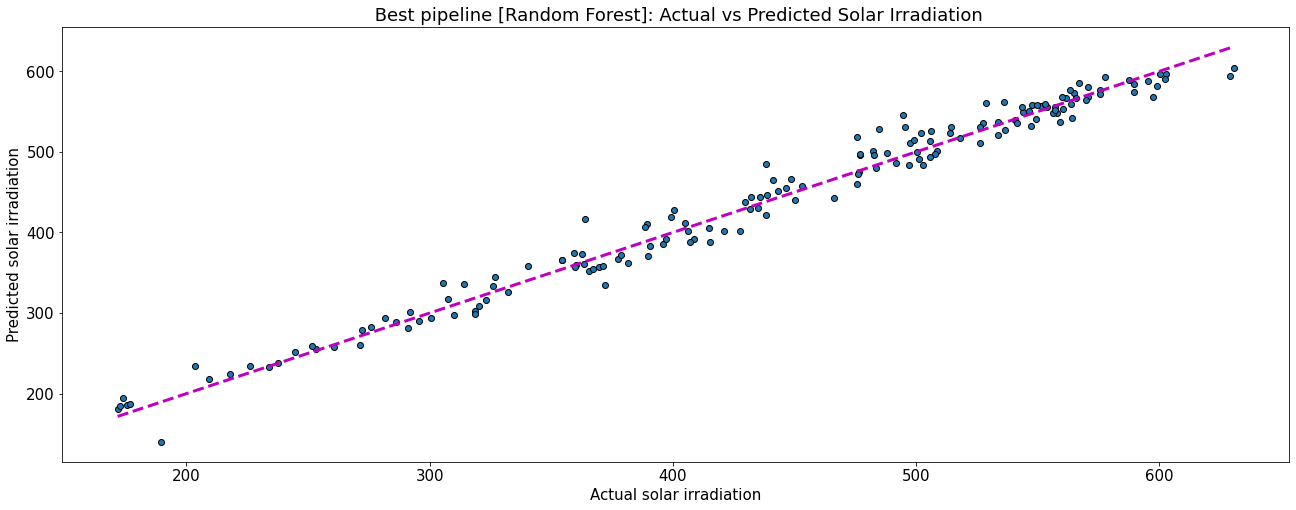

In [20]:
# run the model against the test data presented through a plot
fig, ax = plt.subplots(figsize=(22,8))

ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=3)
ax.set_xlabel('Actual solar irradiation')
ax.set_ylabel('Predicted solar irradiation')
ax.set_title(" Best pipeline [Random Forest]: Actual vs Predicted Solar Irradiation");

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


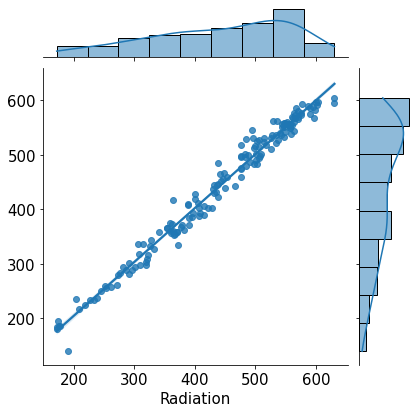

In [21]:
sns.jointplot(y_test, y_pred, kind='reg', ax=ax)
plt.show()